# Imports 

In [2]:
import glob
import cv2 as cv
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from heatmap import heatmap, corrplot

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import pickle

###  PoreAnalyzer Package  ################################################################################

from analyzer.classificator import Preprocessing, DimensionReductionPCA, KMeansClassifier, DBSCANClassifier
from analyzer.features import Pore

# Pore seperation and Feature Extraktion

In [ ]:
# Poren einzeln aus Bildern auslesen und speichern
images = [filepath for filepath in glob.iglob('Images/Ti6Al4V-Stichprobe_4/Images/*.jpg')]
process_time = []

# lists for extracted features
solidity = []
area = []
defect_density = []
perimeter = []
mean_conv_defect = []
img_names = []
pore_number = []
images_index = []
pore_index = []

# try: 
#     os.makedirs('Images/AlSi35_Analysis/all_pores')
# except OSError:
#     pass

for i, image in enumerate(images):
    
    # if i == 2:
    #     break
    image_saved = False

    time_zero = time.time() # Zeit zum Beginn des Loops speichern
    
    img = cv.imread(image, cv.IMREAD_UNCHANGED) # Bild laden
    head_tail = os.path.split(image)
    names_split = int(os.path.splitext(head_tail[1])[0].removesuffix('_4'))    
    
    try: 
        specimen=Micrograph(img, scale=1.79, cropsize_microns=2000)
    except:
        continue
    
    for j, pore in enumerate(specimen.prs):
        pore_sep = PoreSeperator(pore.contour, specimen.img_cnt, segmentsize=0.1)
        pore_index.append(str(i) + '_' + str(j))
        if pore_sep.check_size() == True:
            pore_sep.save('Images/Ti6Al4V-Stichprobe_4/pores/{}_{}.jpg'.format(names_split, j))#i,j))
            image_saved = True
            
            # save features of saved pore in list
            solidity.append(pore.solidity)
            area.append(pore.area)
            defect_density.append(pore.defect_density)
            perimeter.append(pore.perimeter)
            mean_conv_defect.append(pore.mean_defect)
            img_names.append(names_split)
            pore_number.append(j)
            images_index.append(str(i) + '_' + str(j))
        
    process_time.append(time.time()-time_zero)
    time_pending = (len(images)-i-1)*sum(process_time)/len(process_time)
    pending_hours = int(time_pending*0.01666666/60)
    pending_minutes = int(time_pending*0.01666666-(60*pending_hours))
    print('\r Image {:03d} of {}, time pending: {:02d} h {:02d} Min'.format(i+1, len(images), pending_hours, pending_minutes), end="") 

In [ ]:
dataframe = {'img': img_names, 'pore_number': pore_number, 'image_index': images_index,'solidity': solidity, 'area': area, 'defect_density': defect_density, 'perimeter': perimeter, 'mean_defect': mean_conv_defect}

dataframe = pd.DataFrame.from_dict(dataframe)
dataframe

In [ ]:
dataframe.to_csv('Images/AlSi10Mg_Pores/AlSi10Mg_Pore_Features.csv', sep=';', decimal=",", index=False)

In [3]:
dataframe = pd.read_csv('Images/Ti6Al4V_Analysis/Ti6Al4V_Pore_Features.csv', sep=';', decimal=",")
dataframe

,img,pore_number,image_index,solidity,area,defect_density,perimeter,mean_defect
0,1,10,0_10,1.000000,2.647731,0.000000,6.178982,0.000000
1,1,11,0_11,0.967033,13.705900,14.592256,14.590443,0.301292
2,1,12,0_12,0.967553,487.649677,2.460783,87.136394,0.506548
3,1,13,0_13,0.961538,70.086987,8.560790,32.529606,0.340241
4,1,14,0_14,0.974747,420.833417,4.277227,78.071054,0.381112
...,...,...,...,...,...,...,...,...
90061,98,657,634_657,0.788834,374.108759,1.871114,102.786982,2.095467
90062,98,658,634_658,1.000000,0.622995,0.000000,3.157202,0.000000
90063,98,659,634_659,0.965517,4.360968,22.930689,8.084522,0.249599
90064,98,660,634_660,0.898734,11.058169,36.172354,15.842106,0.290443


# Import Labeled Data

In [4]:
# loading image names for the pores in the label folders
images_kh = [filepath for filepath in glob.iglob('Images\Ti6Al4V_Analysis\labeled\Keyhole\*.jpg')]
images_lof = [filepath for filepath in glob.iglob('Images\Ti6Al4V_Analysis\labeled\Lack_of_Fusion\*.jpg')]
images_process = [filepath for filepath in glob.iglob('Images\Ti6Al4V_Analysis\labeled\Process\*.jpg')]

In [5]:
# loading images and label number 
img = []
labels = []
for image in images_kh:
    img.append(cv.resize(cv.imread(image, cv.IMREAD_GRAYSCALE), dsize=(100, 100), interpolation=cv.INTER_CUBIC))
    # img.append(cv.imread(image, cv.IMREAD_GRAYSCALE))
    labels.append(0)
    
for image in images_lof:
    img.append(cv.resize(cv.imread(image, cv.IMREAD_GRAYSCALE), dsize=(100, 100), interpolation=cv.INTER_CUBIC))
    # img.append(cv.imread(image, cv.IMREAD_GRAYSCALE))
    labels.append(1)
    
for image in images_process:
    img.append(cv.resize(cv.imread(image, cv.IMREAD_GRAYSCALE), dsize=(100, 100), interpolation=cv.INTER_CUBIC))
    # img.append(cv.imread(image, cv.IMREAD_GRAYSCALE))
    labels.append(2)
    
images = images_kh + images_lof + images_process

In [6]:
len(img)

1200

## Pixelfeatures

In [5]:
# flattening images into one long vector
data_px = Preprocessing(img)

In [6]:
data_px.dataframe.to_csv('Images/Ti6Al4V_Analysis/Ti6Al4V_Pore_PX_flattened.csv', sep=';', decimal=",", index=False)

In [6]:
# linear dimension reduction to 250 principle components
data_red = DimensionReductionPCA(data_px.dataframe, k=250)
data_red.pca_explain()

Varianz explained by PCA model with 250 Components is 96.888 %.


In [7]:
data_red.save_pca_model(name='Models/PCA_Model_Binary_RF')

PCA Model saved as Models/PCA_Model_Binary_RF.pickle


In [ ]:
# scaling data if wanted
data_red = data_red.dataframe #.scale()

## Local Features

In [9]:
# all features are contained in dataframe --> extracted features of all pores in dataset 

# slicing name of image
names_kh = [os.path.splitext(os.path.split(image)[1])[0] for image in images_kh]
names_lof = [os.path.splitext(os.path.split(image)[1])[0] for image in images_lof]
names_process = [os.path.splitext(os.path.split(image)[1])[0] for image in images_process]

# combining lists
labeled_pores = names_kh + names_lof + names_process

# selecting rows by combined list
local_features = dataframe[dataframe['image_index'].isin(labeled_pores)]

# adding label to dataframe
key_hole = [0 for i in range(len(names_kh))]
lof = [1 for i in range(len(names_lof))]
process = [2 for i in range(len(names_process))]

labels = key_hole + lof + process
    
local_features['label'] = labels

local_features

# local_features.to_csv('Images/Ti6Al4V_Analysis/Ti6Al4V_local_defect_features.csv', sep=';', decimal=",", index=False)

C:\Users\altmann\AppData\Local\Temp\ipykernel_7948\4138243829.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_features['label'] = labels


,img,pore_number,image_index,solidity,area,defect_density,perimeter,mean_defect,label
0,1,10,0_10,1.000000,2.647731,0.000000,6.178982,0.000000,0
1,1,11,0_11,0.967033,13.705900,14.592256,14.590443,0.301292,0
5,1,15,0_15,0.983010,2469.086661,1.579531,192.730405,0.448664,0
6,1,17,0_17,0.964029,20.870347,19.165949,17.285284,0.275446,0
10,1,22,0_22,1.000000,5.139712,0.000000,8.411461,0.000000,0
...,...,...,...,...,...,...,...,...,...
90055,98,651,634_651,0.848485,4.360968,45.861377,9.200762,0.379539,2
90061,98,657,634_657,0.788834,374.108759,1.871114,102.786982,2.095467,2
90063,98,659,634_659,0.965517,4.360968,22.930689,8.084522,0.249599,2
90064,98,660,634_660,0.898734,11.058169,36.172354,15.842106,0.290443,2


# Unsupervised Models

## kMeans

In [8]:
data_red_labeled = data_red.dataframe
data_red_labeled['labels'] = labels
data_red_labeled

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca241,pca242,pca243,pca244,pca245,pca246,pca247,pca248,pca249,labels
0,255.425598,-1785.702271,925.004456,-647.859558,558.293701,-352.141418,-539.285645,-457.659058,81.950119,-70.469582,...,-14.266523,47.727501,24.730694,-25.180429,40.024025,16.892918,53.906643,-17.681454,30.339476,0
1,803.354980,-2022.260864,837.281555,433.116974,-408.251678,193.452789,582.161194,264.769287,-683.036194,174.103912,...,-2.078821,35.566795,15.871997,-34.090492,-36.830696,-15.575199,-51.617443,-81.089500,-49.171860,0
2,2319.719727,-2092.848877,-420.375305,-251.272079,512.934448,1146.280273,-162.358948,-497.942871,-366.308472,47.767113,...,-57.140324,-55.582756,57.236565,90.583664,-1.161246,14.537497,42.300175,-20.864361,-2.166484,0
3,-1407.126343,-684.353210,968.245789,23.670799,32.504410,-1071.493164,143.973633,79.708427,646.462952,-257.145782,...,64.606071,-6.576953,-96.657280,3.912672,-26.863323,26.665403,46.656254,-2.380642,48.228252,0
4,-963.219238,-1100.291626,1195.094727,-167.957077,82.295097,-1099.581055,-66.005585,140.388641,540.216675,-121.797462,...,25.663364,-57.522728,5.548359,0.370564,27.228884,-36.064571,-23.228437,-37.614681,67.636894,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,-2778.831543,924.899963,-434.967377,-16.103178,-23.349348,242.882431,-37.833126,-41.775177,-119.164337,43.505074,...,11.097609,-11.073200,-13.253596,5.406798,-17.156864,-7.780338,-24.389185,-10.724975,-5.443770,2
1196,-2698.895264,819.713989,-325.541809,-12.013907,-24.603376,109.989647,-37.048916,-21.737972,-2.622002,6.201177,...,-13.437889,-0.313441,-10.381701,19.763344,25.998217,-5.259857,3.201698,-32.150646,-23.819143,2
1197,-2780.819824,928.235535,-437.094635,-16.398756,-21.832441,247.764145,-35.915752,-42.458527,-121.828156,43.289146,...,16.934982,-24.733269,-19.361279,6.819247,-23.084692,-11.625570,1.362972,-16.261547,-4.318679,2
1198,-2794.181641,948.835876,-456.649323,-16.779737,-22.549208,278.220184,-31.817270,-44.791748,-148.217529,50.467155,...,-2.029772,-4.704618,9.033099,5.793400,-10.758887,-7.331745,1.210876,-14.464475,-0.857857,2


In [9]:
X = data_red_labeled.drop(['labels'], axis=1)
Y = data_red_labeled['labels']

In [10]:
# splitting data into training and test partition
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [18]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_train)

C:\Users\altmann\Miniconda3\envs\poreClustering\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\altmann\Miniconda3\envs\poreClustering\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [19]:
labels_pred_kmeans = kmeans.predict(X_test)

In [11]:
modelkmeans = KMeansClassifier(X_train)

In [12]:
modelkmeans.train(k=3)

C:\Users\altmann\Miniconda3\envs\poreClustering\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [13]:
labels_pred_kmeans = modelkmeans.predict(X_test)

In [20]:
len(labels_pred_kmeans)

360

In [15]:
len(X_test)

360

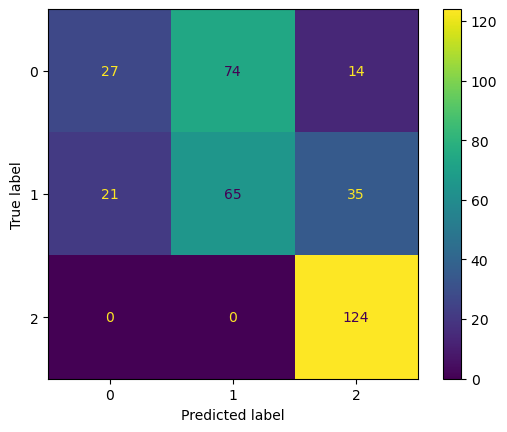

In [21]:
cm = confusion_matrix(y_test, labels_pred_kmeans)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
try: 
    os.makedirs('Images/Ti6Al4V_Analysis/results/results_kmeans/0')
    os.makedirs('Images/Ti6Al4V_Analysis/results/results_kmeans/1')
    os.makedirs('Images/Ti6Al4V_Analysis/results/results_kmeans/2')
    # os.makedirs('pore_label/3')
except OSError:
    pass
    
for i, image in enumerate(images):
    label = labels_pred_kmeans[i]
    img = cv.resize(cv.imread(image), dsize=(100, 100), interpolation=cv.INTER_CUBIC)
    cv.imwrite('Images/Ti6Al4V_Analysis/results/results_kmeans/{}/{}.jpg'.format(label, i), img)

## DBSCAN

### Pixel Features

In [ ]:
modeldbscan = DBSCANClassifier(data_red.scale(), n_neighbors=2, min_samples=2)

In [ ]:
modeldbscan.knee

In [ ]:
modeldbscan.n_clusters

In [ ]:
labels_pred_dbscan = modeldbscan.labels

In [ ]:
for i in range(-1, modeldbscan.n_clusters, 1):
    try:
        os.makedirs('Images/Ti6Al4V_Analysis/results/results_dbscan/{}'.format(i))
    except OSError:
        pass
    
for i, image in enumerate(images):
    label = labels_pred_dbscan[i]
    img = cv.resize(cv.imread(image), dsize=(100, 100), interpolation=cv.INTER_CUBIC)
    cv.imwrite('Images/Ti6Al4V_Analysis/results/results_dbscan/{}/{}.jpg'.format(label, i), img)

In [ ]:
cm = confusion_matrix(results['labels'], labels_pred_dbscan+1)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

### local Features

In [ ]:
modeldbscan_lf = DBSCANClassifier(X)

In [ ]:
modeldbscan_lf.knee

In [ ]:
modeldbscan_lf.n_clusters

In [ ]:
labels_pred_dbscan = modeldbscan_lf.labels

In [ ]:
cm = confusion_matrix(sampling['label'], labels_pred_dbscan+1)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# Supervised Models

## Binary Image Features

In [58]:
# mixing data rows --> data shouldnt be sorted for splitting 
data_sample = results.copy().sample(frac=1).reset_index(drop=True)
X = data_sample.drop(['labels'], axis=1)
Y = data_sample['labels']

In [11]:
# scaling / normalizing the features

# copy the dataframe
df_norm = X.copy()
# apply min-max scaling
for column in df_norm.columns:
    df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())

X = df_norm

In [59]:
sampling = X.copy()
sampling['labels'] = Y
sampling.sample(6)

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca241,pca242,pca243,pca244,pca245,pca246,pca247,pca248,pca249,labels
794,-2790.063965,941.363220,-450.876312,-16.881285,-23.757185,266.390656,-35.812542,-43.869370,-139.339478,50.013527,...,18.105705,-4.226239,2.247457,-21.606541,5.672059,0.113089,2.938675,11.760774,11.556808,2
190,-2674.676758,787.409058,-292.080841,-12.459249,-23.545973,69.260490,-40.746521,-12.490017,33.843327,-2.004482,...,3.731455,-0.126414,-19.827976,0.332897,0.464469,2.854188,-4.628636,-10.954101,-17.088339,2
1024,1825.270142,933.722900,1387.870728,589.914185,-3328.892822,381.851166,-1327.042969,405.855927,653.255737,513.292725,...,158.745773,28.839203,32.630306,78.671585,46.219593,20.289433,51.244339,43.788345,-39.064026,1
519,-2783.756348,931.952576,-441.249786,-16.820127,-22.943647,252.919617,-36.649456,-42.258301,-126.112091,46.502876,...,22.024841,15.041027,-9.137911,-17.108101,4.355286,-3.861822,-2.752205,20.779800,-5.226222,2
707,-2585.554199,673.569702,-177.155655,-11.210746,-24.361341,-63.133881,-39.087746,14.608357,139.730865,-38.287655,...,50.294846,-23.780457,-8.237935,-23.447460,8.493696,1.241484,18.593523,16.175735,6.343253,2
125,-968.545288,-1103.645142,1213.158813,-135.158432,61.409969,-1121.710205,-16.381384,171.112793,562.359192,-147.075012,...,13.519430,7.000445,7.265800,45.118504,-5.014089,24.601515,-31.845251,31.636017,49.224628,0


In [60]:
# splitting data into training and test partition
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

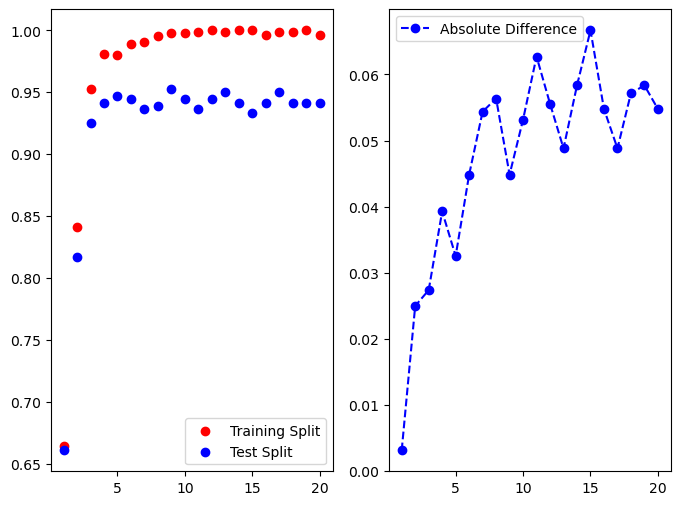

In [61]:
accuracies = []
rf_ = []
k = range(1,21)
for i in k:
    rf = RandomForestClassifier(max_depth=i, n_estimators=15, max_features=100)
    rf.fit(X_train, y_train)
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    
    rf_.append(rf)
    accuracies.append([accuracy_train, accuracy_test])
    
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,2,1)
ax.scatter(k, [elmnt[0] for elmnt in accuracies], c='r', label='Training Split')
ax.scatter(k, [elmnt[1] for elmnt in accuracies], c='b', label='Test Split')
ax.legend()
ax1 = fig.add_subplot(1,2,2)
ax1.plot(k, [abs(elmnt[0]-elmnt[1]) for elmnt in accuracies], 'bo--', label='Absolute Difference')
ax1.legend()
plt.show()

In [63]:
rf = rf_[8]
y_pred_test = rf.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy Test:", accuracy_test)

y_pred_train = rf.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Accuracy Train:', accuracy_train)

Accuracy Test: 0.9527777777777777
Accuracy Train: 0.9976190476190476


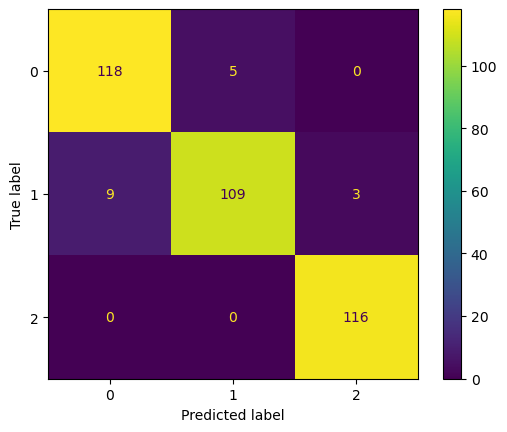

In [64]:
##### Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [65]:
pickle.dump(rf, open('Models/Classifier_Model_Binary_RF'+'.pickle', 'wb'))

## Local Extracted Features

In [ ]:
# mixing data rows --> data shouldnt be sorted for splitting 
data_sample = local_features.copy().sample(frac=1).reset_index(drop=True)
X = data_sample.drop(['label', 'img', 'pore_number', 'image_index'], axis=1)
Y = data_sample['label']

In [ ]:
# scaling / normalizing the features

# copy the dataframe
df_norm = X.copy()
# apply min-max scaling
for column in df_norm.columns:
    df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())

X = df_norm

In [ ]:
sampling = X.copy()
sampling['label'] = Y
sampling.sample(6)

In [ ]:
# splitting data into training and test partition
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [ ]:
accuracies = []
rf_ = []
k = range(1,21)
for i in k:
    rf = RandomForestClassifier(max_depth=i, n_estimators=200, max_features=5)
    rf.fit(X_train, y_train)
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    
    rf_.append(rf)
    accuracies.append([accuracy_train, accuracy_test])
    
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,2,1)
ax.scatter(k, [elmnt[0] for elmnt in accuracies], c='r', label='Training Split')
ax.scatter(k, [elmnt[1] for elmnt in accuracies], c='b', label='Test Split')
ax.legend()
ax1 = fig.add_subplot(1,2,2)
ax1.plot(k, [abs(elmnt[0]-elmnt[1]) for elmnt in accuracies], 'bo--', label='Absolute Difference')
ax1.legend()
plt.show()

In [ ]:
rf = rf_[5]
y_pred_test = rf.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy Test:", accuracy_test)

y_pred_train = rf.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Accuracy Train:', accuracy_train)

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
# plt.figure(figsize=(50,50))
corr = sampling.corr(numeric_only=True)
corrplot(corr, size_scale=500, marker="s")
# plt.savefig('Images/Results/{}/KorrPlot.pdf'.format(dataset))
plt.show()

# Results

In [8]:
results = data_red.dataframe

In [9]:
results['labels'] = labels

In [ ]:
results['labels'] = labels
results['predicted_kmeans'] = labels_pred_kmeans

In [ ]:
results['predicted_dbscan'] = labels_pred_dbscan

In [ ]:
results

In [ ]:
sampling.to_csv('Images/Ti6Al4V_Analysis/Ti6Al4V_labeled_prepared_data.csv', sep=';', decimal=",", index=False)

# ANN Model

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(60,40,20), random_state=1, max_iter=10000000)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
mlp_predicted = clf.predict(X_train)
# Create the confusion matrix
cm = confusion_matrix(y_train, mlp_predicted)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
mlp_predicted = clf.predict(X_test)
# Create the confusion matrix
cm = confusion_matrix(y_test, mlp_predicted)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# Final Model Test

In [181]:
# load pore images from different material to classify
images = [filepath for filepath in glob.iglob('Images/Ti6Al4V-Stichprobe_4/pores/405/*.jpg')]

# read and resize pore binary image
img = [(cv.resize(cv.imread(image, cv.IMREAD_GRAYSCALE), dsize=(100, 100), interpolation=cv.INTER_CUBIC)) for image in images]
print('{} pores found!'.format(len(images)))

436 pores found!


In [182]:
# push image data in pipeline

# flattening images into one long vector
data_px = Preprocessing(img)

# reducing dimensions with pretrained pca model
data_red = DimensionReductionPCA(data_px.dataframe, k=249, pca_model='Models/PCA_Model_Binary_RF')
data_red.pca_explain()

Varianz explained by PCA model with 249 Components is 96.833 %.


In [183]:
# load classifier
classifier = pickle.load(open('Models/Classifier_Model_Binary_RF.pickle', 'rb'))

In [184]:
# classify pores
y_pred = classifier.predict(data_red.dataframe)

In [185]:
# save pores depending by predicted label
try: 
    os.makedirs('Images/Ti6Al4V-Stichprobe_4/results/405/0')
    os.makedirs('Images/Ti6Al4V-Stichprobe_4/results/405/1')
    os.makedirs('Images/Ti6Al4V-Stichprobe_4/results/405/2')
    
except OSError:
    pass
    
for i, image in enumerate(images):
    label = y_pred[i]
    img = cv.resize(cv.imread(image), dsize=(100, 100), interpolation=cv.INTER_CUBIC)
    cv.imwrite('Images/Ti6Al4V-Stichprobe_4/results/405/{}/{}.jpg'.format(label, i), img)